## Some Exploratory Data Analysis


In [20]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = "data"

edu_train_data = "module_Education_train_set.csv"
edu_test_data = "module_Education_test_set.csv"
house_train_data = "module_HouseholdInfo_train_set.csv"
house_test_data = "module_HouseholdInfo_test_set.csv"
pov_train_data = "module_SubjectivePoverty_train_set.csv"
sample_submission_data = "sample_submission.csv"

edu_train = pd.read_csv(os.path.join(DATA_DIR, edu_train_data))
edu_test = pd.read_csv(os.path.join(DATA_DIR, edu_test_data))
house_train = pd.read_csv(os.path.join(DATA_DIR, house_train_data))
house_test = pd.read_csv(os.path.join(DATA_DIR, house_test_data))
pov_train = pd.read_csv(os.path.join(DATA_DIR, pov_train_data))
sample_submission = pd.read_csv(os.path.join(DATA_DIR, sample_submission_data))

# remove all columns except the first one for sample_submission
sample_submission = sample_submission.iloc[:, 0]

### Let's start with Subjective Poverty first


(5337, 11)


/var/folders/92/lv5lwsyj6pq0h_8d0gm14m680000gn/T/ipykernel_85732/2405359640.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(range(10)))


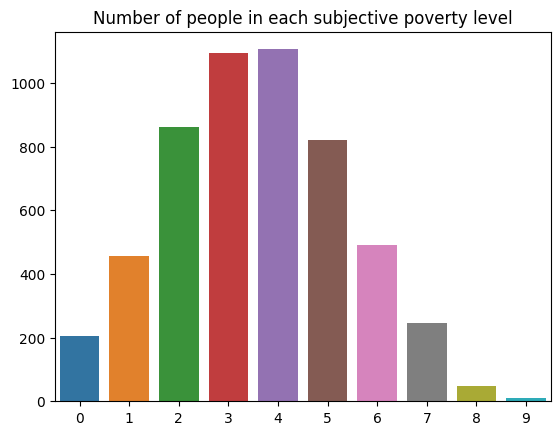

In [2]:
print(pov_train.shape)

# a very normal like distribution!
ax = sns.barplot(pov_train.iloc[:, 1:], estimator="sum", errorbar=None)
ax.set_xticklabels(list(range(10)))
plt.title("Number of people in each subjective poverty level")
plt.show()

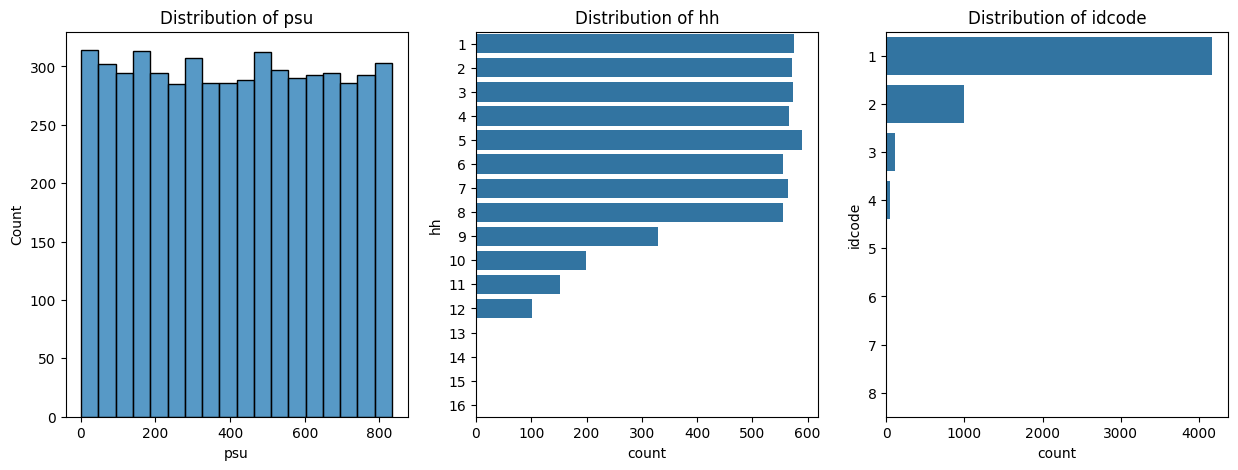

In [3]:
pov_train[["psu", "hh", "idcode"]] = (
    pov_train["psu_hh_idcode"].str.split("_", expand=True).astype(int)
)
# plot the distribution of psu, hh, and idcode
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(pov_train["psu"], ax=ax[0])
ax[0].set_title("Distribution of psu")
sns.countplot(pov_train["hh"].astype(str), ax=ax[1], order=list(range(1, 17)))
ax[1].set_title("Distribution of hh")
sns.countplot(pov_train["idcode"].astype(str), ax=ax[2], order=list(range(1, 9)))
ax[2].set_title("Distribution of idcode")
plt.show()

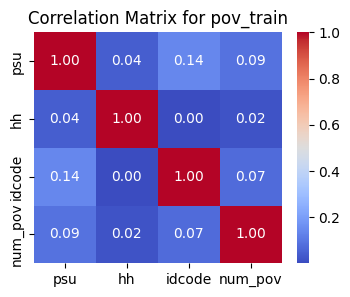

In [4]:
# we might as well convert it to a range of 1-10
# I also tried with just the classes themselves, but not much difference in the correlation matrix
pov_train["num_pov"] = (
    pov_train.iloc[:, 1:11].idxmax(axis=1).str.split("_").str[-1].astype(int)
)
# Calculate the correlation matrix
corr = pov_train[["psu", "hh", "idcode", "num_pov"]].corr()

# Generate a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for pov_train")
plt.show()

### Then Education data


In [5]:
edu_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 69 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   psu     22406 non-null  int64  
 1   hh      22406 non-null  int64  
 2   idcode  22406 non-null  int64  
 3   q01     22406 non-null  int64  
 4   q02     22406 non-null  int64  
 5   q03     22406 non-null  int64  
 6   q04     21513 non-null  float64
 7   q05     21513 non-null  float64
 8   q06     21513 non-null  float64
 9   q07     21513 non-null  float64
 10  Q08     21513 non-null  float64
 11  Q09     5565 non-null   float64
 12  Q10     39 non-null     float64
 13  Q11     15948 non-null  float64
 14  Q12     5526 non-null   float64
 15  Q13     5526 non-null   float64
 16  Q14     21513 non-null  float64
 17  Q15     5625 non-null   float64
 18  Q16     35 non-null     float64
 19  Q17     15888 non-null  float64
 20  Q18     15888 non-null  float64
 21  Q19     15923 non-null  float64
 22

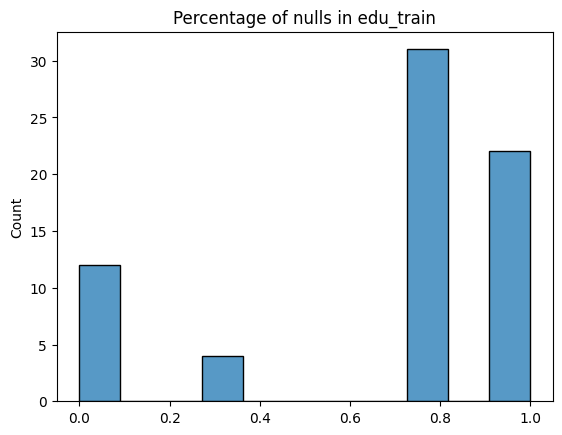

In [6]:
# there are a lot of nulls in the data
# we might as well just take the columns that have less than 50% nulls
# since we also have too many features to work with
sns.histplot(edu_train.isnull().sum(axis=0) / edu_train.shape[0])
plt.title("Percentage of nulls in edu_train")
plt.show()

['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q14']


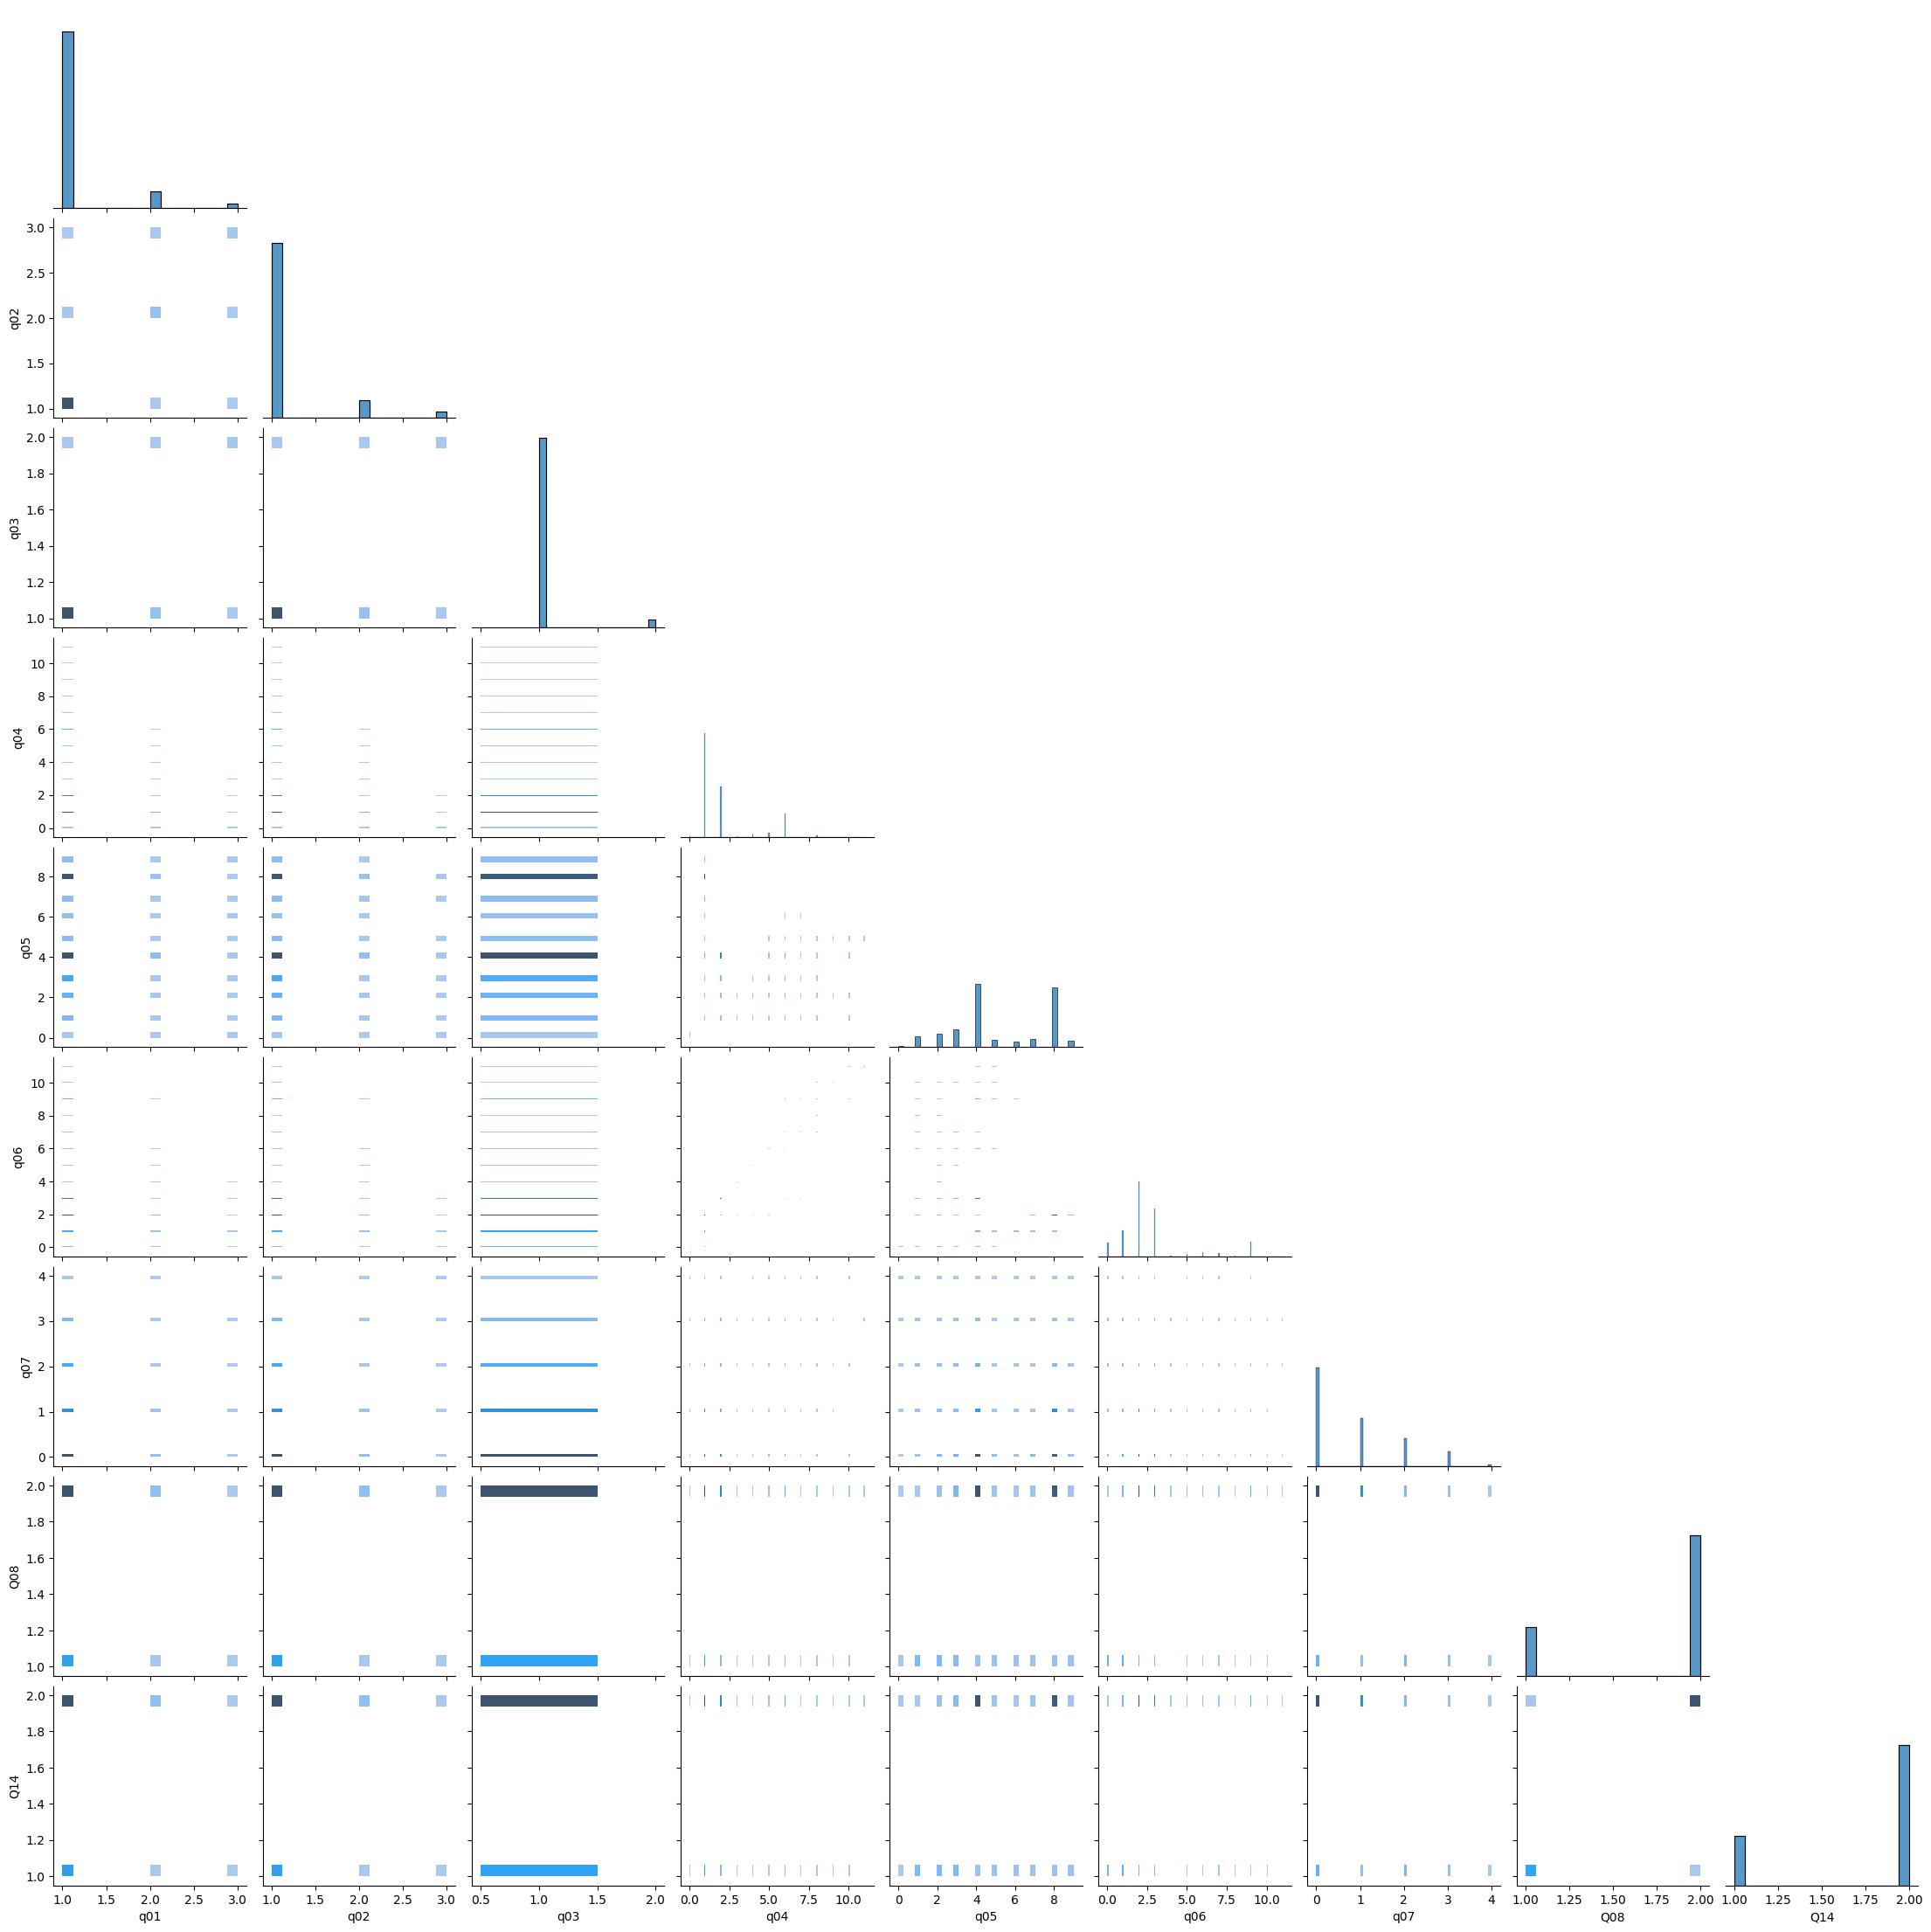

In [7]:
# they look pretty random to me, except for q4 and q6
# q4 and q6 are both related to education level, so it makes sense that they are correlated:
# q4) What is the highest grade [Name] have completed in school? In which level?
# q6) What is the highest diploma [Name] have attained?
threshold = 0.2
edu_selected_columns = edu_train.isnull().sum(axis=0) / edu_train.shape[0] < threshold
edu_selected_columns = edu_selected_columns[edu_selected_columns].index.tolist()

# they don't seem to have correlations, so I'm removing them from the plot for clarity
edu_selected_columns.remove("psu")
edu_selected_columns.remove("hh")
edu_selected_columns.remove("idcode")

sns.pairplot(edu_train[edu_selected_columns], kind="hist", corner=True)
print(edu_selected_columns)

In [8]:
# q1) Can [Name] read the newspaper?
# q2) Can [Name] write a one page personal letter?
# q3) Has [Name] ever attended school?
# q4, 5) What is the highest grade [Name] have completed in school? In which level?
# q6) What is the highest diploma [Name] have attained?
# q7) How many years of preschool did [Name] attend?
# q8) Did [Name] enroll or has you plans to enroll in school this academic year?
# q14) Did [NAME] enroll in the past academic year?

# q1-3 are somewhat related to each other (about their level of literacy)
# also q3 can terminate the survey if the answer is no. We might consider removing it too.

# q4 indicates most attended ["8 OR 9  YEARS" SCHOOL] or [GYMNAZIUM(SECONDARY GENERAL)]
# q5 range differs as it depends on q4, might consider removing it

# q7 appears like a 1/x distribution

# q8 & 14 these two appears to be closely related, the ones that didn't enroll in the past year are likely to not enroll in the current year

### The Household Data


In [9]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24001 entries, 0 to 24000
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   psu     24001 non-null  int64  
 1   hh      24001 non-null  int64  
 2   idcode  24001 non-null  int64  
 3   hhid    24001 non-null  int64  
 4   q02     24001 non-null  int64  
 5   q03     24001 non-null  int64  
 6   q04     24001 non-null  int64  
 7   q05y    24001 non-null  int64  
 8   q05m    24001 non-null  int64  
 9   q06     20465 non-null  float64
 10  q07     12148 non-null  float64
 11  q08     11761 non-null  float64
 12  q09     24001 non-null  int64  
 13  q10     24001 non-null  int64  
 14  q11     24001 non-null  int64  
 15  q12     11728 non-null  float64
 16  q13     12273 non-null  float64
 17  q14     12273 non-null  float64
 18  q15     6386 non-null   float64
 19  q16     5887 non-null   float64
 20  q17     24001 non-null  int64  
 21  q18     10697 non-null  float64
 22

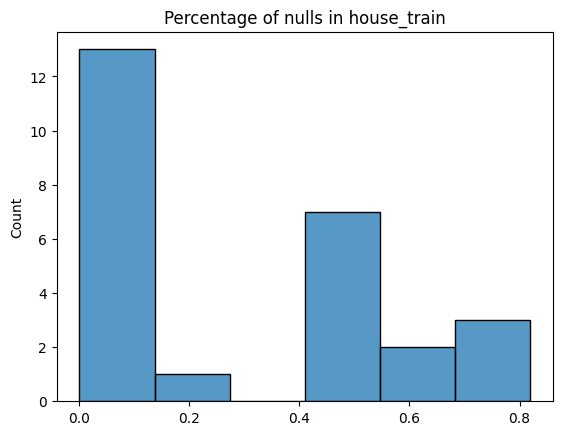

In [10]:
# Again, there are a lot of nulls in the data
# we might as well just take the columns that have less than 50% nulls
# since we also have too many features to work with
sns.histplot(house_train.isnull().sum(axis=0) / house_train.shape[0])
plt.title("Percentage of nulls in house_train")
plt.show()

['q02', 'q03', 'q04', 'q05y', 'q05m', 'q06', 'q09', 'q10', 'q11', 'q17']


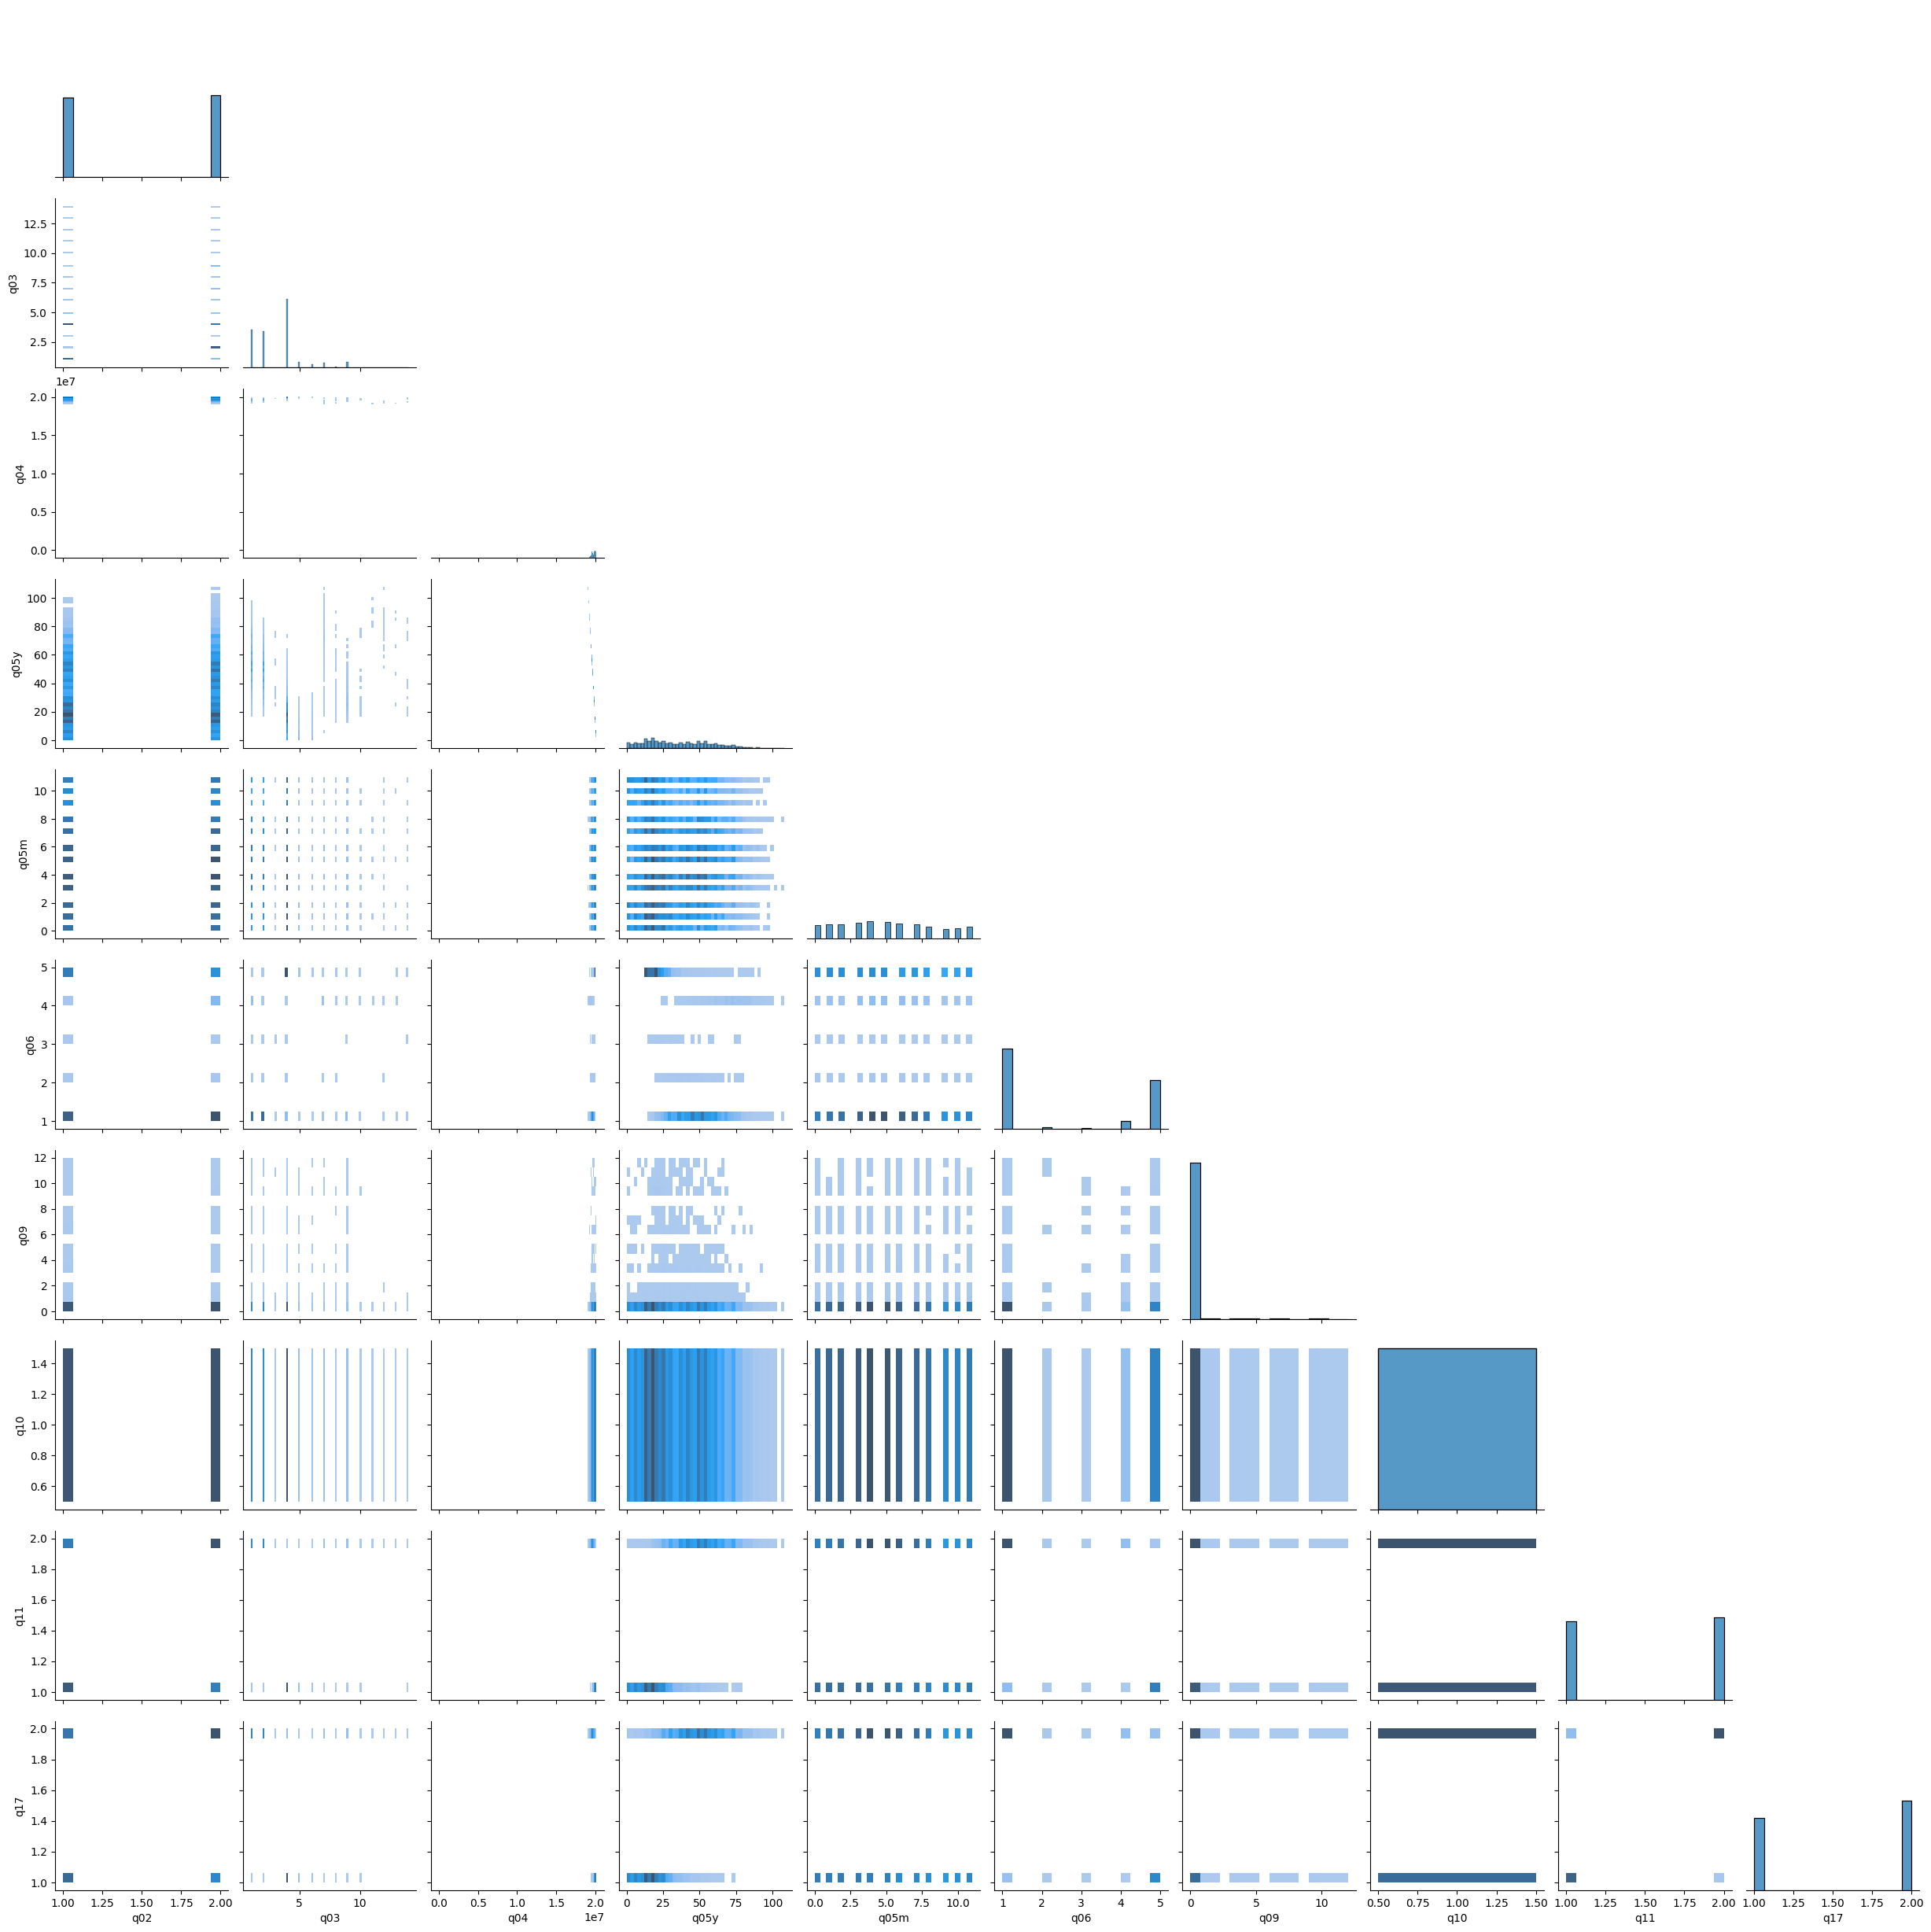

In [11]:
# same as edu_train
threshold = 0.2
house_selected_columns = (
    house_train.isnull().sum(axis=0) / house_train.shape[0] < threshold
)
house_selected_columns = house_selected_columns[house_selected_columns].index.tolist()

# they don't seem to have correlations, so I'm removing them from the plot for clarity
house_selected_columns.remove("psu")
house_selected_columns.remove("hh")
house_selected_columns.remove("hhid")  # this is just combination of psu and hh
house_selected_columns.remove("idcode")

sns.pairplot(house_train[house_selected_columns], kind="hist", corner=True)
print(house_selected_columns)

In [12]:
# q2) SEX
# q3) RELATIONSHIP TO HEAD:
# q4) DATE OF BIRTH:
# q5) How old is [NAME]?
# q6) What is the present marital status of [NAME]?
# q9) For how many months during the past 12 months (since MONTH/ YEAR) has he/she been away from this household?
# q10) Household Member Present?
# q11) Does the natural mother of [NAME] live in this household now?
# q17) Does the natural father of [NAME] live in this household now?

# q6 & (q11 | q17) somewhat related, if married then the parents are likely to not live in the same household
# q9 most people have just haven't left their household in the past 12 months
# q10 only 1 value... might consider removing it
# q11 & q17 are related to each other, if one is true, the other is likely to be true too

### Combining


In [ ]:
# let's first see how many training data rows we actually have
house_train["psu_hh_idcode"] = (
    house_train["psu"].astype(str)
    + "_"
    + house_train["hh"].astype(str)
    + "_"
    + house_train["idcode"].astype(str)
)
edu_train["psu_hh_idcode"] = (
    edu_train["psu"].astype(str)
    + "_"
    + edu_train["hh"].astype(str)
    + "_"
    + edu_train["idcode"].astype(str)
)
house_train_prefixed = house_train.drop(
    columns=["psu", "hh", "idcode", "hhid"]
).add_prefix("house_")
edu_train_prefixed = edu_train.drop(columns=["psu", "hh", "idcode"]).add_prefix("edu_")

# remove prefix on the key merge column "psh_hh_idcode"
house_train_prefixed = house_train_prefixed.rename(
    columns={"house_psu_hh_idcode": "psu_hh_idcode"}
)
edu_train_prefixed = edu_train_prefixed.rename(
    columns={"edu_psu_hh_idcode": "psu_hh_idcode"}
)

combined_train = pd.merge(
    pd.merge(
        pov_train,
        house_train_prefixed,
        on="psu_hh_idcode",
        how="left",
        suffixes=[None, "_house"],
    ),
    edu_train_prefixed,
    on="psu_hh_idcode",
    how="left",
    suffixes=[None, "_edu"],
)
combined_train.shape, pov_train.shape  # same number of rows

((5337, 103), (5337, 15))

In [15]:
combined_train.to_csv(os.path.join("processed", "combined_train.csv"), index=False)

In [ ]:
# now test data
house_test["psu_hh_idcode"] = (
    house_test["psu"].astype(str)
    + "_"
    + house_test["hh"].astype(str)
    + "_"
    + house_test["idcode"].astype(str)
)
edu_test["psu_hh_idcode"] = (
    edu_test["psu"].astype(str)
    + "_"
    + edu_test["hh"].astype(str)
    + "_"
    + edu_test["idcode"].astype(str)
)
house_test_prefixed = house_test.drop(
    columns=["psu", "hh", "idcode", "hhid"]
).add_prefix("house_")
edu_test_prefixed = edu_test.drop(columns=["psu", "hh", "idcode"]).add_prefix("edu_")

# remove prefix on the key merge column "psh_hh_idcode"
house_test_prefixed = house_test_prefixed.rename(
    columns={"house_psu_hh_idcode": "psu_hh_idcode"}
)
edu_test_prefixed = edu_test_prefixed.rename(
    columns={"edu_psu_hh_idcode": "psu_hh_idcode"}
)

combined_test = pd.merge(
    pd.merge(
        sample_submission,
        house_test_prefixed,
        on="psu_hh_idcode",
        how="left",
        suffixes=[None, "_house"],
    ),
    edu_test_prefixed,
    on="psu_hh_idcode",
    how="left",
    suffixes=[None, "_edu"],
)
combined_test.shape, sample_submission.shape  # same number of rows

((1334, 89), (1334,))

In [22]:
combined_test.to_csv(os.path.join("processed", "combined_test.csv"), index=False)